# Autoencoder for MNIST

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, sys
import shutil
import torch
import torch.nn as nn
from torchvision import transforms
from exercise_code.image_folder_dataset import ImageFolderDataset
from torch.utils.tensorboard import SummaryWriter
from time import sleep
from tqdm import tqdm
from exercise_code.tests.base_tests import bcolors

torch.manual_seed(42)

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # To prevent the kernel from dying.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. The MNIST Dataset

The MNIST Dataset is downloaded via i2dl

In [3]:
transform = transforms.Compose([])
path = os.path.dirname(os.path.abspath(os.getcwd()))
mnist_root = os.path.join(path, "datasets", "mnist")

train_100_dataset = ImageFolderDataset(
    root=mnist_root,
    images="train_images.pt",
    labels="train_labels.pt",
    force_download=False,
    verbose=True,
    transform=transform,
)
val_100_dataset = ImageFolderDataset(
    root=mnist_root,
    images="val_images.pt",
    labels="val_labels.pt",
    force_download=False,
    verbose=True,
    transform=transform,
)
test_100_dataset = ImageFolderDataset(
    root=mnist_root,
    images="test_images.pt",
    labels="test_labels.pt",
    force_download=False,
    verbose=True,
    transform=transform,
)

# We also set up the unlabeled images which we will use later
unlabeled_train = ImageFolderDataset(
    root=mnist_root,
    images="unlabeled_train_images.pt",
    force_download=False,
    verbose=True,
    transform=transform,
)
unlabeled_val = ImageFolderDataset(
    root=mnist_root,
    images="unlabeled_val_images.pt",
    force_download=False,
    verbose=True,
    transform=transform,
)

Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip


The dataset consists of tuples of 28x28 pixel PIL images and a label that is an integer from 0 to 9.

The shape of our greyscale images:  (28, 28)


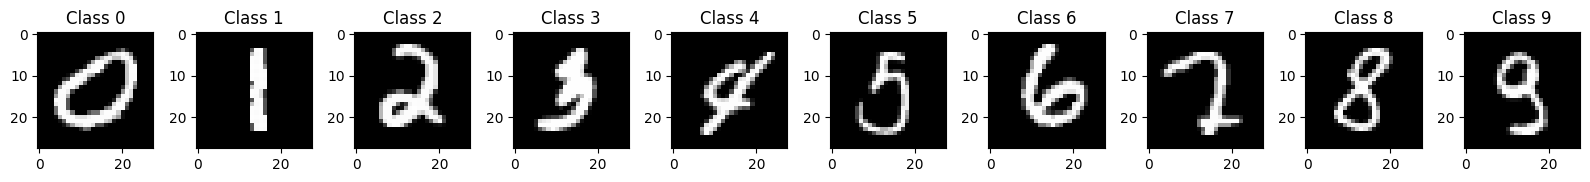

In [4]:
plt.rcParams["figure.figsize"] = (16, 16)  # Make the figures a bit bigger

indices_arr = [83, 98, 92, 99, 78, 97, 90, 95, 93, 96]
for i, index in enumerate(indices_arr):
    image = np.array(
        train_100_dataset[index][0].squeeze()
    )  # get the image of the data sample
    label = train_100_dataset[index][1]  # get the label of the data sample
    plt.subplot(1, 10, i + 1)
    plt.imshow(image, cmap="gray", interpolation="none")
    plt.title("Class {}".format(label))

plt.tight_layout()
print("The shape of our greyscale images: ", image.shape)

## 2.2 The Classifier

In [5]:
hparams = {
    "batch_size": 64,
    "learning_rate": 3e-3,
    "n_hidden_1": 600,
    "n_hidden_2": 300,
    "n_hidden_3": 100,
    "n_hidden_4": 100,
    "latent_size": 32,
    "input_size": 28 * 28,
    "num_classes": 10,
    "num_workers": 2,
    "device": device,
}

## 2.3 Training & Validation Step


In [6]:
def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable), total=len(iterable), ncols=150, desc=desc)


def train_classifier(
    classifier,
    train_loader,
    val_loader,
    loss_func,
    tb_logger,
    epochs=10,
    name="default",
):
    """
    Train the classifier for a number of epochs.
    """
    optimizer = classifier.optimizer
    classifier = classifier.to(device)
    validation_loss = 0
    for epoch in range(epochs):

        training_loss = 0

        # Training stage
        classifier.train()  # Set the model to training mode

        # Create a progress bar for the training loop.
        training_loop = create_tqdm_bar(
            train_loader, desc=f"Training Epoch [{epoch + 1}/{epochs}]"
        )
        for train_iteration, batch in training_loop:
            optimizer.zero_grad()  # Reset the gradients
            images, labels = batch  # Get the images and labels from the batch
            images, labels = images.to(device), labels.to(
                device
            )  # Send the data to the device (GPU or CPU)

            # Flatten the images to a vector.
            # Could also be done by reshaping the images in the dataset.
            images = images.view(images.shape[0], -1)

            pred = classifier(images)  # Stage 1: Forward().
            loss = loss_func(
                pred, labels
            )  # Compute the loss over the predictions and the ground truth.
            loss.backward()  # Stage 2: Backward().
            optimizer.step()  # Stage 3: Update the parameters.

            training_loss += loss.item()

            # Update the progress bar.
            training_loop.set_postfix(
                curr_train_loss="{:.8f}".format(training_loss / (train_iteration + 1)),
                val_loss="{:.8f}".format(validation_loss),
            )

            # Update the tensorboard logger.
            tb_logger.add_scalar(
                f"classifier_{name}/train_loss",
                loss.item(),
                epoch * len(train_loader) + train_iteration,
            )

        # Validation stage
        classifier.eval()
        val_loop = create_tqdm_bar(
            val_loader, desc=f"Validation Epoch [{epoch + 1}/{epochs}]"
        )
        validation_loss = 0
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                images = images.view(images.shape[0], -1)
                pred = classifier(images)
                loss = loss_func(pred, labels)
                validation_loss += loss.item()

                # Update the progress bar.
                val_loop.set_postfix(
                    val_loss="{:.8f}".format(validation_loss / (val_iteration + 1))
                )

                # Update the tensorboard logger.
                tb_logger.add_scalar(
                    f"classifier_{name}/val_loss",
                    loss.item(),
                    epoch * len(val_loader) + val_iteration,
                )
        validation_loss /= len(val_loader)

## 2.4 Fit Classification Model with Trainer

In [7]:
from exercise_code.models import Classifier
from exercise_code.models import Encoder

# Create the encoder and the classifier.
encoder = Encoder(hparams).to(device)
classifier = Classifier(hparams, encoder).to(device)

path = os.path.join("logs", "cls_logs")
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f"run_{num_of_runs + 1}")

tb_logger = SummaryWriter(path)

# Train the classifier.
labled_train_loader = torch.utils.data.DataLoader(
    train_100_dataset, batch_size=hparams["batch_size"], shuffle=True
)
labled_val_loader = torch.utils.data.DataLoader(
    val_100_dataset, batch_size=hparams["batch_size"], shuffle=False
)

epochs = hparams.get("epochs", 10)
loss_func = nn.CrossEntropyLoss()  # The loss function we use for classification.
train_classifier(
    classifier,
    labled_train_loader,
    labled_val_loader,
    loss_func,
    tb_logger,
    epochs=epochs,
    name="Default",
)

print("Finished training!")
print(f"Training Acc: {classifier.getAcc(labled_train_loader)[1] * 100}%")
print(f"Validation Acc: {classifier.getAcc(labled_val_loader)[1] * 100}%")

Validation Epoch [10/10]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 374.88it/s, val_loss=1.29482174]

Finished training!
Training Acc: 98.0%
Validation Acc: 53.0%


# 3. Autoencoder




In [8]:
from exercise_code.models import Autoencoder, Encoder, Decoder

hparams = {
    "batch_size": 128,
    "learning_rate": 3e-3,
    "n_hidden_1": 600,
    "n_hidden_2": 300,
    "n_hidden_3": 100,
    "n_hidden_4": 100,
    "latent_size": 32,
    "input_size": 28 * 28,
    "num_classes": 10,
    "num_workers": 2,
    "device": device,
}
encoder_pretrained = Encoder(hparams).to(device)
decoder = Decoder(hparams).to(device)
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder).to(device)

In [9]:
encoder_pretrained = Encoder(hparams).to(device)
decoder = Decoder(hparams).to(device)
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder).to(device)


def train_model(
    model, train_loader, val_loader, loss_func, tb_logger, epochs=10, name="Autoencoder"
):

    optimizer = model.optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=epochs * len(train_loader) / 5, gamma=0.7
    )
    validation_loss = 0
    model = model.to(device)
    for epoch in range(epochs):

        # Train
        training_loop = create_tqdm_bar(
            train_loader, desc=f"Training Epoch [{epoch}/{epochs}]"
        )
        training_loss = 0
        for train_iteration, batch in training_loop:

            loss = model.training_step(batch, loss_func)
            training_loss += loss.item()
            scheduler.step()

            # Update the progress bar.
            training_loop.set_postfix(
                train_loss="{:.8f}".format(training_loss / (train_iteration + 1)),
                val_loss="{:.8f}".format(validation_loss),
            )

            # Update the tensorboard logger.
            tb_logger.add_scalar(
                f"{name}/train_loss",
                loss.item(),
                epoch * len(train_loader) + train_iteration,
            )

        # Validation
        val_loop = create_tqdm_bar(
            val_loader, desc=f"Validation Epoch [{epoch}/{epochs}]"
        )
        validation_loss = 0
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                loss = model.validation_step(batch, loss_func)
                validation_loss += loss.item()

                # Update the progress bar.
                val_loop.set_postfix(
                    val_loss="{:.8f}".format(validation_loss / (val_iteration + 1))
                )

                # Update the tensorboard logger.
                tb_logger.add_scalar(
                    f"{name}/val_loss",
                    validation_loss / (val_iteration + 1),
                    epoch * len(val_loader) + val_iteration,
                )
        validation_loss /= len(val_loader)


path = os.path.join("logs", "ae_logs")
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f"run_{num_of_runs + 1}")
tb_logger = SummaryWriter(path)

# Train the classifier.
unlabled_train_loader = torch.utils.data.DataLoader(
    unlabeled_train, batch_size=hparams["batch_size"], shuffle=True
)
unlabled_val_loader = torch.utils.data.DataLoader(
    unlabeled_val, batch_size=hparams["batch_size"], shuffle=False
)

epochs = hparams.get("epochs", 5)
loss_func = (
    nn.MSELoss()
)  # The loss function we use for regression (Could also be nn.L1Loss()).
train_model(
    autoencoder,
    unlabled_train_loader,
    unlabled_val_loader,
    loss_func,
    tb_logger,
    epochs=epochs,
    name="Autoencoder",
)

print("Finished training!")

Validation Epoch [4/5]: 100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 325.20it/s, val_loss=0.07633815]

Finished training!


Have a look at the reconstructed validation images

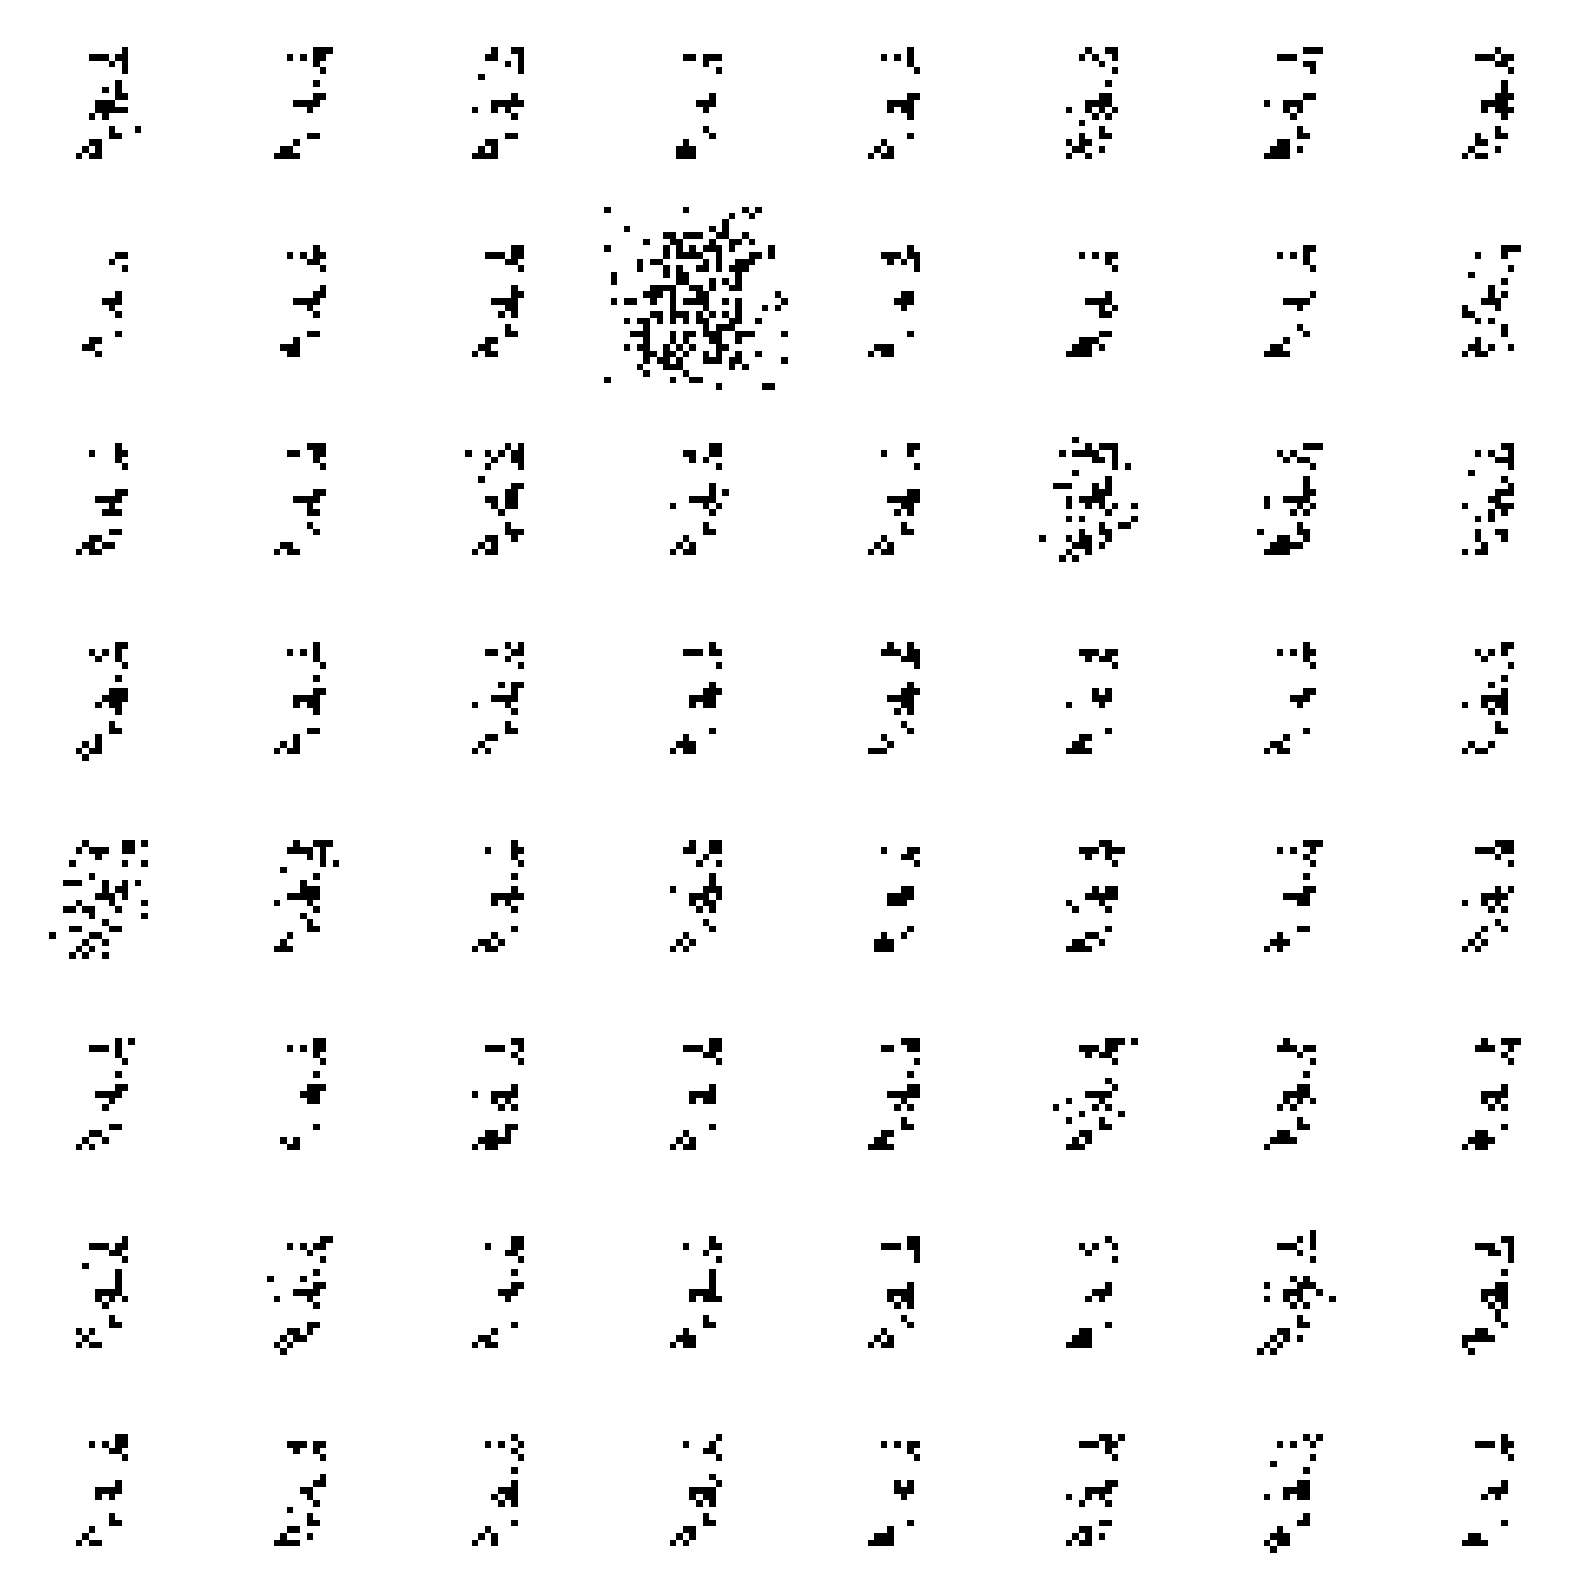

In [10]:
reconstructions = autoencoder.getReconstructions(unlabled_val_loader)
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.axis("off")
    plt.imshow(reconstructions[i], cmap="gray", interpolation="none")

plt.tight_layout()

# 4. Transfer Learning

## 4.1 The pretrained Classifier

Initialize another classifier with the pretrained encoder.

In [11]:
from exercise_code.models import Classifier
from copy import deepcopy

hparams = {
    "batch_size": 128,
    "learning_rate": 3e-3,
    "n_hidden_1": 600,
    "n_hidden_2": 300,
    "n_hidden_3": 100,
    "n_hidden_4": 100,
    "latent_size": 32,
    "input_size": 28 * 28,
    "num_classes": 10,
    "num_workers": 2,
    "device": device,
}

encoder_pretrained_copy = deepcopy(encoder_pretrained)
classifier_pretrained = Classifier(hparams, encoder_pretrained_copy).to(device)

Define another trainer that will utilize the pretrained classifier, to compare its performance with the classifier trained only on the labeled data.

In [12]:
path = os.path.join("logs", "pretrained_cls_logs")
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f"run_{num_of_runs + 1}")
tb_logger = SummaryWriter(path)

batch_size = hparams.get("batch_size", 16)
labled_train_loader = torch.utils.data.DataLoader(
    train_100_dataset, batch_size=batch_size, shuffle=True
)
labled_val_loader = torch.utils.data.DataLoader(
    val_100_dataset, batch_size=batch_size, shuffle=False
)

epochs = hparams.get("epochs", 100)
loss_func = nn.CrossEntropyLoss()  # The loss function we use for classification.
train_classifier(
    classifier_pretrained,
    labled_train_loader,
    labled_val_loader,
    loss_func,
    tb_logger,
    epochs=epochs,
    name="Pretrained",
)

print("Finished training!")

Validation Epoch [100/100]: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 378.75it/s, val_loss=1.07557940]

Finished training!


Look at the validation accuracy of the two different classifiers and compare them.
Look at the test accuracy and compare our two classifiers with respect to that in the very end.

In [13]:
val_acc_scracth = classifier.getAcc(labled_val_loader)[1] * 100
color = "green" if val_acc_scracth > 52 else "red"
print(
    f"Validation accuracy when training from scratch: {bcolors.colorize(color, val_acc_scracth)}%"
)

val_acc_pretrained = classifier_pretrained.getAcc(labled_val_loader)[1] * 100
color = "green" if val_acc_pretrained > 55 else "red"
print(
    f"Validation accuracy with pretraining: {bcolors.colorize(color, val_acc_pretrained)}%"
)

Validation accuracy when training from scratch: 53.0%
Validation accuracy with pretraining: 70.0%


# Save model & Report Test Accuracy

In [14]:
from exercise_code.Util import test_and_save

test_dl = torch.utils.data.DataLoader(test_100_dataset, batch_size=4, shuffle=False)

test_acc = classifier.getAcc(test_dl)[1] * 100
color = "green" if test_acc > 55 else "red"
print(f"Test accuracy when training from scratch: {bcolors.colorize(color, test_acc)}%")

test_acc = classifier_pretrained.getAcc(test_dl)[1] * 100
color = "green" if test_acc > 55 else "red"
print(f"Test accuracy with pretraining: {bcolors.colorize(color, test_acc)}%")

test_and_save(classifier_pretrained, labled_val_loader, test_dl)

Test accuracy when training from scratch: 63.0%
Test accuracy with pretraining: 75.0%
Validation Accuracy: 70.0%
# Paramters: The model has 0.691 mio. params.
Size: Great! The model size is 5.5 MB and is less than 20 MB.
the model has been saved and is ready to be submitted.
